# GPT-4 Turbo with Vision demo - Azure Open AI - Fashion usecase

GPT-4 Turbo with Vision on Azure OpenAI service is now in public preview. GPT-4 Turbo with Vision is a large multimodal model (LMM) developed by OpenAI that can analyze images and provide textual responses to questions about them. It incorporates both natural language processing and visual understanding. With enhanced mode, you can use the Azure AI Vision features to generate additional insights from the images.

> https://learn.microsoft.com/en-us/azure/ai-services/openai/whats-new#gpt-4-turbo-with-vision-now-available

In [1]:
%pip install openai --upgrade

  Using cached httpx-0.27.2-py3-none-any.whl.metadata (7.1 kB)
  Using cached pydantic-2.9.2-py3-none-any.whl.metadata (149 kB)
  Using cached httpcore-1.0.5-py3-none-any.whl.metadata (20 kB)
  Using cached h11-0.14.0-py3-none-any.whl.metadata (8.2 kB)
  Using cached annotated_types-0.7.0-py3-none-any.whl.metadata (15 kB)
Using cached httpx-0.27.2-py3-none-any.whl (76 kB)
Using cached httpcore-1.0.5-py3-none-any.whl (77 kB)
Using cached pydantic-2.9.2-py3-none-any.whl (434 kB)
   ---------------------------------------- 0.0/1.9 MB ? eta -:--:--
   ---------------------------------------- 1.9/1.9 MB 103.5 MB/s eta 0:00:00
Using cached annotated_types-0.7.0-py3-none-any.whl (13 kB)
Using cached h11-0.14.0-py3-none-any.whl (58 kB)
Note: you may need to restart the kernel to use updated packages.


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [1]:
%pip install gradio

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
! pip install python-dotenv

Defaulting to user installation because normal site-packages is not writeable


In [3]:
import base64
import datetime
import gradio as gr
import json
import openai
import os
import requests
import sys

from dotenv import load_dotenv
from io import BytesIO
from PIL import Image

C:\Users\Student\AppData\Roaming\Python\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
def check_openai_version():
    """
    Check Azure Open AI version
    """
    installed_version = openai.__version__

    try:
        version_number = float(installed_version[:3])
    except ValueError:
        print("Invalid OpenAI version format")
        return

    print(f"Installed OpenAI version: {installed_version}")

    if version_number < 1.0:
        print("[Warning] You should upgrade OpenAI to have version >= 1.0.0")
        print("To upgrade, run: %pip install openai --upgrade")
    else:
        print(f"[OK] OpenAI version {installed_version} is >= 1.0.0")

In [5]:
check_openai_version()

Installed OpenAI version: 0.28.1
[Warning] You should upgrade OpenAI to have version >= 1.0.0
To upgrade, run: %pip install openai --upgrade


In [6]:
sys.version

'3.11.5 (tags/v3.11.5:cce6ba9, Aug 24 2023, 14:38:34) [MSC v.1936 64 bit (AMD64)]'

In [7]:
print(f"Today is {datetime.datetime.today().strftime('%d-%b-%Y %H:%M:%S')}")

Today is 19-Sep-2024 11:45:57


In [8]:
print(f"Python version: {sys.version}")

Python version: 3.11.5 (tags/v3.11.5:cce6ba9, Aug 24 2023, 14:38:34) [MSC v.1936 64 bit (AMD64)]


## 1. Azure Open AI

In [9]:
print(f"OpenAI version: {openai.__version__}")

OpenAI version: 0.28.1


In [10]:
load_dotenv("azure.env")

# Azure Open AI
openai.api_type: str = "azure"
openai.api_key = os.getenv("OPENAI_API_KEY")
openai.api_base = os.getenv("OPENAI_API_BASE")

In [11]:
model = "gpt-4"  # This is the deployed name of your GPT4 Vision model from the Azure Open AI studio

## 2. Functions

In [12]:
def image_view(image_file):
    """
    View image
    """
    if not os.path.exists(image_file):
        print(f"[Error] Image file {image_file} does not exist.")
        return None

    else:
        print(image_file)
        img = Image.open(image_file)
        display(img)

In [13]:
def gpt4V_fashion(image_file):
    """
    GPT4-Vision
    """
    # Checking if file exists
    if not os.path.exists(image_file):
        print(f"[Error] Image file {image_file} does not exist.")
        return None

    # Endpoint
    base_url = f"{openai.api_base}/openai/deployments/{model}"
    gpt4vision_endpoint = f"{base_url}/chat/completions?api-version=2023-12-01-preview"

    # Header
    headers = {"Content-Type": "application/json", "api-key": openai.api_key}

    # Encoded image
    base_64_encoded_image = base64.b64encode(open(image_file, "rb").read()).decode(
        "ascii"
    )

    context = """ 
    You are a fashion expert, familiar with identifying features of fashion articles from images.
    A user uploads an image and asks you to describe one particular piece in the shot: jacket, shoes, pants, \
    watches, etc.
    """

    prompt = """
    You respond with your analysis of the following fields:

    1. ITEM'S TYPE: Identify if it's a top, bottom, dress, outerwear, footwear, bag, jewelry...
    2. BRAND: identity the brand of the item.
    3. COLOR: Note the main color(s) and any secondary colors.
    4. PATTERN: Identify any visible patterns such as stripes, florals, animal print, or geometric designs.\
    Feel free to use any other patterns here.
    5. MATERIAL: Best guess at the material that the item is made from.
    6. FEATURES: Note any unique details or embellishments, like embroidery, sequins, studs, fringes, buttons,
    zippers...
    7. ITEM TYPE SPECIFIC: For each type of item, feel free to add any additional descriptions that are relevant \
    to help describe the item. For example, for a jacket you can include the neck and sleeve design, plus the length.
    8. MISC.: Anything else important that you notice.
    9. SIZE: Print the size of the item if you get it from the image.
    10. ITEM SUMMARY: Write a one line summary for this item.
    11. ITEM CLASSIFICATION: Classify this item into CLOTHES, BAG, SHOES, WATCH or OTHERS.
    12. ITEM TAGS: Generate 10 tags to describe this item. Each tags should be separated with a comma.
    13. STORIES: Write multiple stories about this product in 5 lines.
    14. TWEETER PUBLICATION: Write a tweeter ad for this item with some hashtags and emojis.
    15. ECOMMERCE AD: Generate an item description for a publication on a ecommerce website with a selling message.
    16. FRENCH ECOMMERCE AD: Generate an item description in French for a publication on a ecommerce website with \
    a selling message.

    The output should be a numbered bulleted list. Just print an empty line between each items starting at item 12.
    """

    # Prompt
    json_data = {
        "messages": [
            {"role": "system", "content": context},
            {"role": "user", "content": [prompt, {"image": base_64_encoded_image}]},
        ],
        "max_tokens": 4000,
        "temperature": 0.7,
    }

    # Results
    response = requests.post(
        gpt4vision_endpoint, headers=headers, data=json.dumps(json_data)
    )

    if response.status_code == 200:
        now = str(datetime.datetime.today().strftime("%d-%b-%Y %H:%M:%S"))
        print(f"Analysis of image: {image_file}")
        resp = json.loads(response.text)["choices"][0]["message"]["content"]
        print("\033[1;31;34m")
        print(resp)
        print("\n\033[1;31;32mDone:", now)
        print(
            "\033[1;31;32m[Note] These results are generated by an AI (Azure Open AI GPT4-Vision)"
        )

    elif response.status_code == 429:
        print(
            "[429 Error] Too many requests. Please wait a couple of seconds and try again."
        )

    else:
        print("[Error] Error code:", response.status_code)

## 3. Examples

fashion/image1.jpg


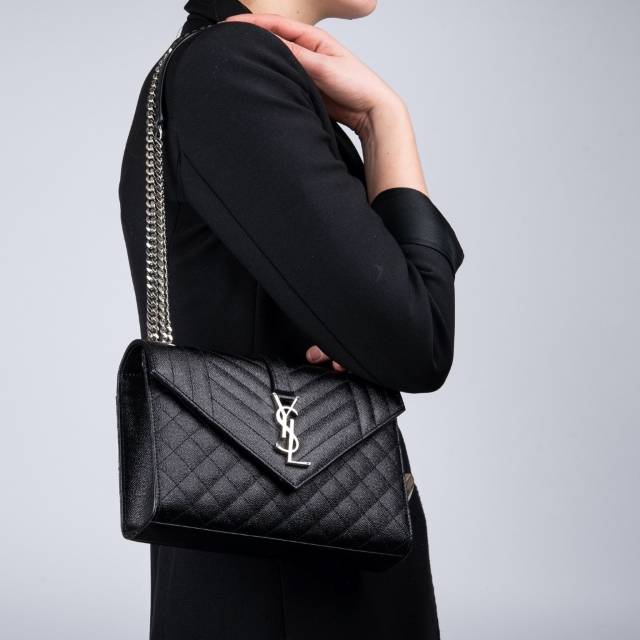

In [14]:
image_file = "fashion/image1.jpg"

image_view(image_file)

In [15]:
gpt4V_fashion(image_file)

Analysis of image: fashion/image1.jpg

1. ITEM'S TYPE: Bag
2. BRAND: Yves Saint Laurent (logo visible)
3. COLOR: Black
4. PATTERN: Quilted with a chevron design
5. MATERIAL: Leather (or a leather-like synthetic)
6. FEATURES: Silver-tone metal YSL logo, chain strap, envelope-style front flap
7. ITEM TYPE SPECIFIC: Envelope clutch with a chain strap that can be worn on the shoulder or across the body, quilted texture, and a prominent designer logo.
8. MISC.: The bag appears to be part of a luxury collection, commonly associated with high fashion and status.
9. SIZE: Not visible
10. ITEM SUMMARY: A luxury black quilted leather envelope clutch with a silver-tone YSL logo and chain strap.
11. ITEM CLASSIFICATION: BAG
12. ITEM TAGS: Luxury, Quilted, Leather, Black, Envelope Clutch, YSL, Designer, Chain Strap, Fashion, Accessory

13. STORIES:
- Step into the world of high fashion with this exquisite black YSL envelope clutch, a statement piece that exudes elegance.
- From a VIP event to an in

### Another example

fashion/image2.jpg


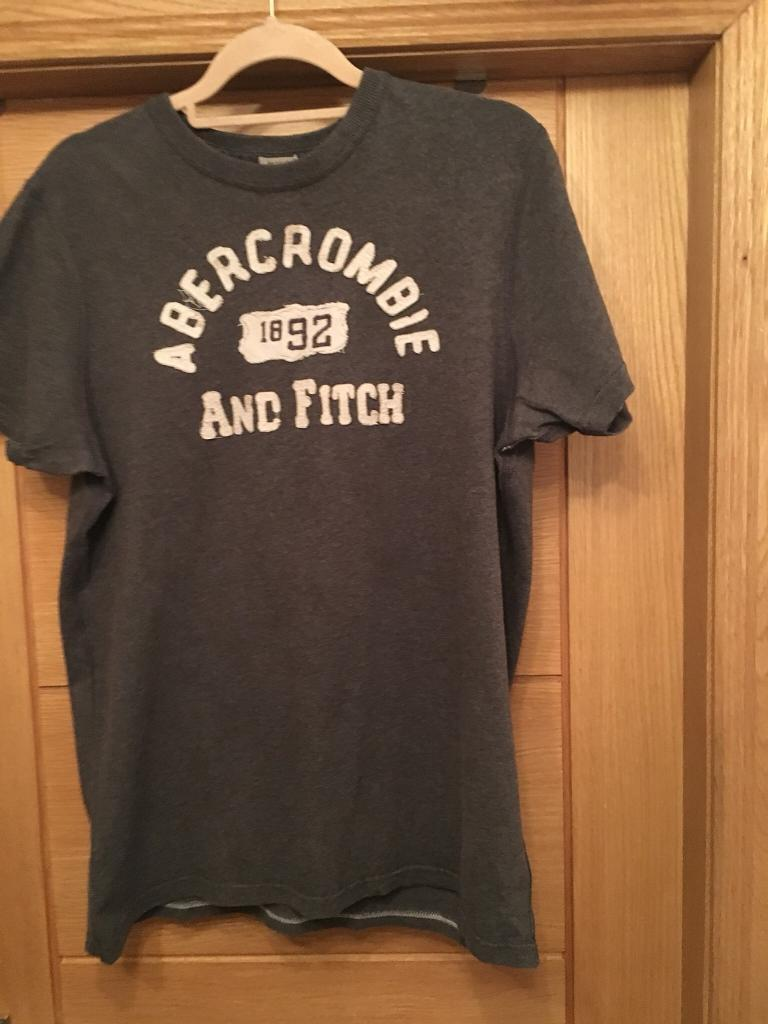

In [16]:
image_file = "fashion/image2.jpg"

image_view(image_file)

In [17]:
gpt4V_fashion(image_file)

Analysis of image: fashion/image2.jpg

1. ITEM'S TYPE: Top (T-shirt)
2. BRAND: Abercrombie & Fitch
3. COLOR: Heather Grey
4. PATTERN: Logo Print
5. MATERIAL: Appears to be cotton or a cotton blend
6. FEATURES: Distressed logo graphic
7. ITEM TYPE SPECIFIC: Short sleeve, crew neck, regular fit
8. MISC.: The item appears to be casual wear
9. SIZE: Not visible in the image
10. ITEM SUMMARY: A casual heather grey Abercrombie & Fitch T-shirt with a distressed logo graphic.
11. ITEM CLASSIFICATION: CLOTHES

12. ITEM TAGS: Abercrombie & Fitch, T-shirt, casual, heather grey, distressed logo, short sleeve, crew neck, cotton, fashion, everyday wear

13. STORIES:
- This T-shirt tells a story of casual comfort with its soft cotton blend and easy-to-wear style.
- The distressed logo adds a touch of vintage charm, suggesting a well-loved piece with a backstory.
- Perfect for a laid-back weekend, it's a classic piece that pairs well with jeans or shorts.
- As part of an effortless wardrobe, it speaks

### Another example

fashion/image3.png


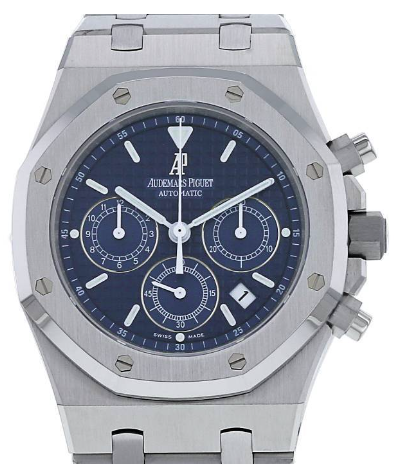

In [18]:
image_file = "fashion/image3.png"

image_view(image_file)

In [19]:
gpt4V_fashion(image_file)

Analysis of image: fashion/image3.png

1. ITEM'S TYPE: This is a watch.
2. BRAND: The brand of the watch is Audemars Piguet.
3. COLOR: The main color is silver, with a blue watch face and white detailing.
4. PATTERN: No distinct pattern, but a chronograph design with subdials.
5. MATERIAL: The watch appears to be made of stainless steel.
6. FEATURES: This watch features a date window, chronograph subdials, screw-locked crown, and pushpieces.
7. ITEM TYPE SPECIFIC: This watch has a Royal Oak case shape, a glare-proof sapphire crystal, and a bracelet with a folding clasp.
8. MISC.: The watch has luminous hands and hour markers for visibility in the dark.
9. SIZE: The size of the watch cannot be determined from the image.
10. ITEM SUMMARY: A luxury stainless steel Audemars Piguet watch with a blue face and chronograph functionality.
11. ITEM CLASSIFICATION: WATCH.
12. ITEM TAGS: luxury, timepiece, Audemars Piguet, chronograph, stainless steel, sapphire crystal, Royal Oak, luminous, blue d

### Another example

fashion/image4.jpg


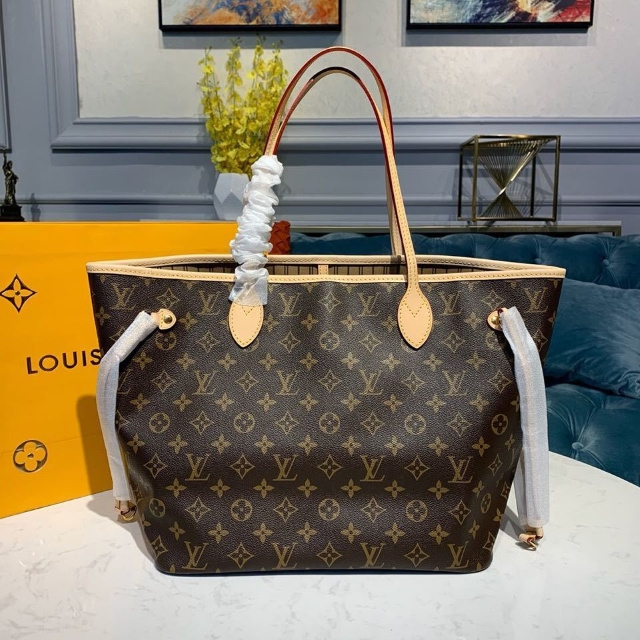

In [20]:
image_file = "fashion/image4.jpg"

image_view(image_file)

In [22]:
gpt4V_fashion(image_file)

Analysis of image: fashion/image4.jpg

1. ITEM'S TYPE: Bag (Tote Bag)
2. BRAND: Louis Vuitton
3. COLOR: Brown, Tan, and Gold
4. PATTERN: Monogram
5. MATERIAL: Coated Canvas with Natural Cowhide Leather Trim
6. FEATURES: Gold-tone hardware, leather handles, monogram pattern, side laces that can be tightened to create a more compact silhouette
7. ITEM TYPE SPECIFIC: Tote bag with a wide, open top for easy access, structured shape, and a flat base to stand upright
8. MISC.: The bag has an attached scarf or twilly wrapped around one of the handles, which is a common accessory used to personalize designer bags.
9. SIZE: Not visible in the image.
10. ITEM SUMMARY: A classic Louis Vuitton monogram tote bag with elegant leather detailing and versatile side laces for adjustable shape.
11. ITEM CLASSIFICATION: BAG
12. ITEM TAGS: Louis Vuitton, designer, tote bag, monogram, luxury, leather trim, gold hardware, fashion, style, accessory

13. STORIES: 
- This iconic tote bag is a staple in the worl

### Another example

fashion/image5.jpg


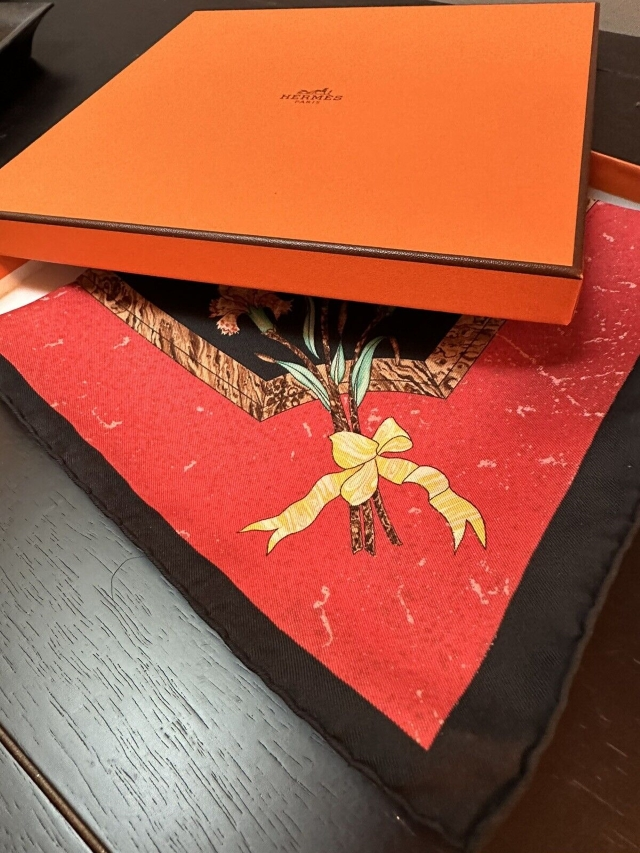

In [23]:
image_file = "fashion/image5.jpg"

image_view(image_file)

In [24]:
gpt4V_fashion(image_file)

Analysis of image: fashion/image5.jpg

1. ITEM'S TYPE: This appears to be a top, most likely a shirt.
2. BRAND: The brand is not clearly visible on the shirt; the orange box above is branded Hermès.
3. COLOR: The main color of the shirt is red with a black border.
4. PATTERN: The shirt features a floral pattern with what appears to be a bow or ribbon.
5. MATERIAL: The material cannot be determined with certainty from the image, but it appears to be a woven fabric, possibly silk or a silk blend, given the sheen and the type of print.
6. FEATURES: The shirt has a floral pattern with detailed print, likely indicative of a high-quality or designer garment.
7. ITEM TYPE SPECIFIC: Since only a small part of the shirt is visible, details such as neck and sleeve design cannot be determined. The visible portion shows a flat seam that suggests a neat, tailored finish.
8. MISC.: There is an orange Hermès box partially covering the shirt, suggesting that the shirt could be a luxury item, possibly 

### Another example

fashion/image6.png


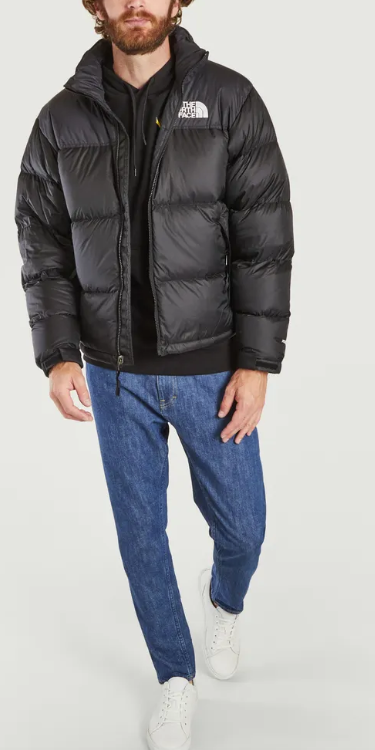

In [25]:
image_file = "fashion/image6.png"

image_view(image_file)

In [26]:
gpt4V_fashion(image_file)

Analysis of image: fashion/image6.png

1. ITEM'S TYPE: Outerwear (Jacket)
2. BRAND: The North Face
3. COLOR: Black
4. PATTERN: Solid color with quilted stitching
5. MATERIAL: Likely synthetic insulating materials and waterproof or water-resistant outer shell
6. FEATURES: Quilted puffer design, full-zip front, stand-up collar, side pockets, elastic cuffs, and a visible logo on the chest
7. ITEM TYPE SPECIFIC: Puffer jacket with a hip-length cut and a regular fit
8. MISC.: The jacket appears to be part of a casual, outdoor, or sporty collection, suitable for cold weather
9. SIZE: Not visible in the image
10. ITEM SUMMARY: A black quilted puffer jacket by The North Face, designed for warmth and comfort in cold conditions
11. ITEM CLASSIFICATION: CLOTHES

12. ITEM TAGS: The North Face, puffer jacket, black, quilted, insulated, outdoor, winter wear, sporty, casual, waterproof

13. STORIES:
- Braving the chill has never been so stylish with this sleek The North Face puffer jacket.
- Conquer 

### Another example

fashion/image7.jpg


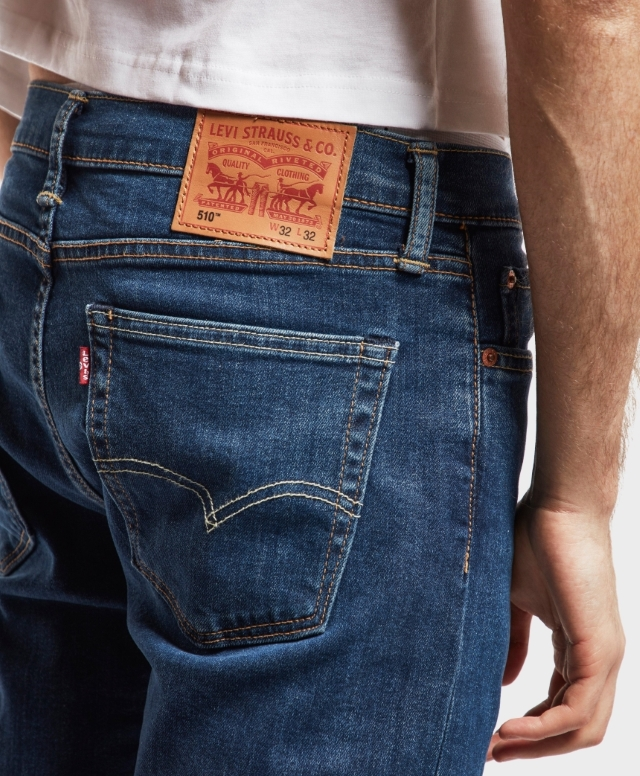

In [27]:
image_file = "fashion/image7.jpg"

image_view(image_file)

In [28]:
gpt4V_fashion(image_file)

Analysis of image: fashion/image7.jpg

1. ITEM'S TYPE: Bottom (Jeans)
2. BRAND: Levi's
3. COLOR: Main color is blue (denim)
4. PATTERN: No visible pattern, classic denim texture
5. MATERIAL: Denim (cotton or cotton blend)
6. FEATURES: Red Levi's tag, signature arcuate stitching on back pockets, leather brand patch on the waistband, button and zipper closure, belt loops.
7. ITEM TYPE SPECIFIC: These are Levi’s 510 jeans which are typically a skinny fit, with a mid-rise waist and a slim leg.
8. MISC.: The jeans have a five-pocket design, which is standard for most denim jeans.
9. SIZE: W32 L32 (as indicated on the leather brand patch)
10. ITEM SUMMARY: Classic blue Levi's 510 skinny jeans with signature details.
11. ITEM CLASSIFICATION: CLOTHES
12. ITEM TAGS: denim, Levi's, jeans, skinny, blue, casual, cotton, durable, mid-rise, stylish

13. STORIES:
- A timeless staple in every wardrobe, these Levi's jeans offer a perfect blend of comfort and style.
- Rugged yet refined, these denim pan

### Another example

fashion/image8.jpg


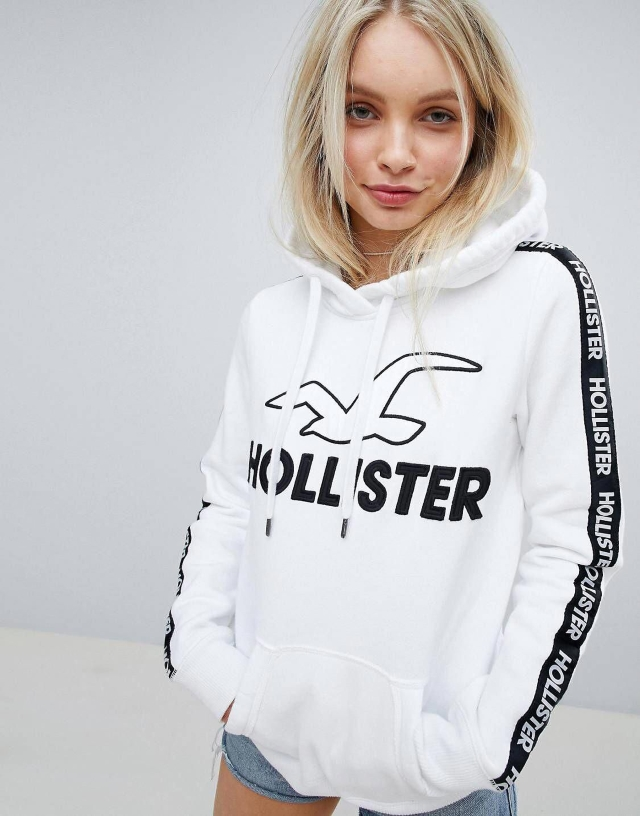

In [29]:
image_file = "fashion/image8.jpg"

image_view(image_file)

In [30]:
gpt4V_fashion(image_file)

Analysis of image: fashion/image8.jpg

1. ITEM'S TYPE: This is a hoodie.
2. BRAND: The hoodie is branded with the Hollister logo.
3. COLOR: The primary color of the hoodie is white.
4. PATTERN: There is no pattern, but there is brand text and logo graphics.
5. MATERIAL: It appears to be made from a cotton blend typical for hoodies.
6. FEATURES: The hoodie has a kangaroo pocket, ribbed cuffs, and a drawstring hood. Branding is also featured along the sleeves.
7. ITEM TYPE SPECIFIC: This hoodie has long sleeves, a hood with drawstrings, and a kangaroo pouch pocket. It seems to be a standard length, not cropped, and has a relaxed fit.
8. MISC.: The hoodie has a large graphic logo on the front and branding down the sleeves.
9. SIZE: The size is not visible in the image.
10. ITEM SUMMARY: A white Hollister graphic logo hoodie with sleeve branding.
11. ITEM CLASSIFICATION: CLOTHES.

12. ITEM TAGS: hoodie, Hollister, white, graphic logo, casual wear, long sleeve, kangaroo pocket, drawstring h

## 4. Gradio WebApp

In [31]:
def gpt4V_fashion_webapp(pil_image):
    """
    GPT4-Vision
    """
    # Endpoint
    base_url = f"{openai.api_base}/openai/deployments/{model}"
    gpt4vision_endpoint = f"{base_url}/chat/completions?api-version=2023-12-01-preview"

    # Header
    headers = {"Content-Type": "application/json", "api-key": openai.api_key}

    # Encoded PIL image
    buffered = BytesIO()
    pil_image.save(buffered, format="JPEG")
    base_64_encoded_image = base64.b64encode(buffered.getvalue()).decode("ascii")

    context = """ 
    You are a fashion expert, familiar with identifying features of fashion articles from images.
    A user will upload an image and asks you to describe one particular piece in the shot: jacket, shoes, pants, \
    watches, etc.
    """

    prompt = """
    You respond with your analysis of the following fields:

    1. ITEM'S TYPE: Identify if it's a top, bottom, dress, outerwear, footwear, bag, jewelry...
    2. BRAND: identity the brand of the item.
    3. COLOR: Note the main color(s) and any secondary colors.
    4. PATTERN: Identify any visible patterns such as stripes, florals, animal print, or geometric designs.\
    Feel free to use any other patterns here.
    5. MATERIAL: Best guess at the material that the item is made from.
    6. FEATURES: Note any unique details or embellishments, like embroidery, sequins, studs, fringes, buttons,
    zippers...
    7. ITEM TYPE SPECIFIC: For each type of item, feel free to add any additional descriptions that are relevant \
    to help describe the item. For example, for a jacket you can include the neck and sleeve design, plus the length.
    8. MISC.: Anything else important that you notice.
    9. SIZE: Print the size of the item if you get it from the image.
    10. ITEM SUMMARY: Write a one line summary for this item.
    11. ITEM CLASSIFICATION: Classify this item into CLOTHES, BAG, SHOES, WATCH or OTHERS.
    12. ITEM TAGS: Generate 10 tags to describe this item. Each tags should be separated with a comma.
    13. STORIES: Write multiple stories about this product in 5 lines.
    14. TWEETER PUBLICATION: Write a tweeter ad for this item with some hashtags and emojis.
    15. ECOMMERCE AD: Generate an item description for a publication on a ecommerce website with a selling message.
    16. FRENCH ECOMMERCE AD: Generate an item description in French for a publication on a ecommerce website with \
    a selling message.

    The output should be a numbered bulleted list. Just print an empty line between each items starting at item 12.
    """

    # Prompt
    json_data = {
        "messages": [
            {"role": "system", "content": context},
            {"role": "user", "content": [prompt, {"image": base_64_encoded_image}]},
        ],
        "max_tokens": 4000,
        "temperature": 0.7,
    }

    # Results
    response = requests.post(
        gpt4vision_endpoint, headers=headers, data=json.dumps(json_data)
    )

    if response.status_code == 200:
        resp = json.loads(response.text)["choices"][0]["message"]["content"]
        resp1, resp2 = resp.split("13. STORIES:", 1)
        resp1 = resp1.replace("\n\n", "")
        resp2 = "13. STORIES:" + resp2
        return resp1, resp2

    elif response.status_code == 429:
        msg1 = "[429 Error] Too many requests. Please wait a couple of seconds and try again."
        msg2 = msg1
        return msg1, msg2

    else:
        msg1 = str(response.status_code)
        msg2 = msg1
        return msg1, msg2

In [33]:
image_url = (
    "https://raw.githubusercontent.com/retkowsky/images/master/fashion-logo-design.jpg"
)
logo = "<center> <img src= {} width=200px></center>".format(image_url)
title = "GPT-4 Vision demo with Azure Open AI - Fashion usecase"

examples = [
    "fashion/image1.jpg",
    "fashion/image2.jpg",
    "fashion/image3.png",
    "fashion/image4.jpg",
    "fashion/image5.jpg",
    "fashion/image6.png",
    "fashion/image7.jpg",
    "fashion/image8.jpg",
]

inputs = gr.Image(type="pil", label="Your image")
outputs = [
    gr.Text(label="Product image insights"),
    gr.Text(label="Marketing content"),
]

theme = "rottenlittlecreature/Moon_Goblin"
# https://huggingface.co/spaces/gradio/theme-gallery

gpt4V_fashion_gradiowebapp = gr.Interface(
    fn=gpt4V_fashion_webapp,
    inputs=inputs,
    outputs=outputs,
    description=logo,
    title=title,
    examples=examples,
    theme=theme,
)

In [34]:
gpt4V_fashion_gradiowebapp.launch(share=True)

Running on local URL:  http://127.0.0.1:7860
Running on public URL: https://2ff42978d9a6fe3914.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
